In [19]:
graph = nx.Graph()
print(graph)

Graph with 0 nodes and 0 edges


In [20]:
# This is a trick taught by Jesús to include the directory containing the source 
# within the notebook scope
import sys
sys.path.append('../')

In [201]:
import networkx as nx
import spacy 
from spacy.lang.es.examples import sentences
import itertools as it
import matplotlib.pyplot as plt

from spacy.symbols import nsubj, VERB, root, ORTH, PUNCT

MODEL = 'es_core_news_sm'
MODEL = 'es_core_news_lg'

# MODEL = 'en_core_web_md'
# MODEL = 'es_core_news_lg'

# we centralize the extraction
nlp = spacy.load(MODEL)

# Add special case rule
special_case = [{ORTH: "D/Dª"}]
nlp.tokenizer.add_special_case("D/Dª", special_case)

# pattern = [{'LIKE_NUM': True},
#            {'IS_LOWER': True}]

ruler = nlp.add_pipe("entity_ruler")
patterns = [ {"label": "DNI", "pattern": [{"TEXT": {"REGEX": ".*?[0-9]{8}[A-Z]"}}]}, 
             {"label": "DNI", "pattern": [{"LOWER": "dni"}, {"TEXT": {"REGEX": ".*?[0-9]{8}[A-Z]"}}] },
             {"label": "DNI", "pattern": [{"LOWER": "dni"}, {}, {"TEXT": {"REGEX": ".*?[0-9]{8}[A-Z]"}}] },
           ]
ruler.add_patterns(patterns)


def is_idx_part_of_entity(idx,dep_parse):
    # print(f'is_idx: {idx} - {dep_parse[idx]}')
    for i in range(len(dep_parse.ents)):
        # print(f'ent: {dep_parse.ents[i].start} - {dep_parse.ents[i].end} : {[dep_parse[x] for x in range(dep_parse.ents[i].start, dep_parse.ents[i].end)]}')
        if dep_parse.ents[i].start <= idx and idx <= dep_parse.ents[i].end:
            return True
    return False

def build_graph_from_dependencies (doc): 
    edges = []
    edge_labels = {}
    roots = []
    for token in doc:
        if token.dep_=='ROOT': 
            roots.append(token)
        for child in token.children:
            edges.append(('{0}'.format(token.i),
                          '{0}'.format(child.i)))
            edge_labels [('{0}'.format(token.i),
                          '{0}'.format(child.i)) ]= child.dep_
    if len(roots) > 1: 
        # we have to reconstruct the graph -- maybe bad partitioning due to punctuation in our context
        # This is completely heuristic as we are dealing with Spanish texts, we try to reconstruct the 
        # connectivity of the sentence by assuming local dependency 
        # if we don't see any punctuation nearby => we include a meta-root node
        sorted_roots = sorted(roots, key=lambda x: x.i)
        meta_roots = set()
        meta_roots.add(sorted_roots[0])
        sorted_roots.pop(0)
        for crt_root in sorted_roots: 
            if crt_root.i-2 > 0: 
                if doc[crt_root.i-1].pos == PUNCT: 
                    print (f'{crt_root} - {doc[crt_root.i-2]}')
                    edges.append(('{0}'.format(crt_root.i),
                                  '{0}'.format(crt_root.i-2)))
                    edge_labels [('{0}'.format(crt_root.i),
                          '{0}'.format(crt_root.i-2)) ]= 'REC'
                else: 
                    meta_roots.add(crt_root)
            else: 
                meta_roots.add(crt_root)
        if len(meta_roots) >1: 
            for crt_root in meta_roots: 
                edges.append(('-1','{0}'.format(crt_root.i)))
                edge_labels [('-1','{0}'.format(crt_root.i)) ]= 'META_ROOT'
    
    graph = nx.Graph()
    graph.add_edges_from(edges)
    
    color_state_map = {'no_root': 'pink', 'root': 'red', 'meta_root': 'blue'}
    states = ['meta_root' if node=='-1' else 'root' if doc[int(node)].dep_ == 'ROOT'  else 'no_root' for node in graph.nodes()]
    nx.set_node_attributes(graph, dict(zip(graph.nodes(), states)), 'state')
    node_labels = {n:doc[int(n)] for n in graph.nodes()}
    plt.figure(figsize=(10,10))
    pos = nx.spring_layout(graph, seed=225, )  # Seed for reproducible layout
    nx.draw(
        graph, pos, edge_color='black', width=1, linewidths=1, 
        node_color=[color_state_map[node[1]['state']] for node in graph.nodes(data=True)], 
        alpha=0.9,
        labels=node_labels
    )
    nx.draw_networkx_edge_labels(
        graph, pos, edge_labels=edge_labels,
        font_color='red'
    )
    plt.show()
    return graph

def check_path_crossing_another_entity (doc, path): 
    if (len(path) == 2): 
        return False
    else: 
        return any([ ent.start<= int(idx) and int(idx)<ent.end for idx in path[1:-1] for ent in doc.ents ])
    

def shortest_dependency_path(graph, e1=None, e2=None):
    ## CB: This should also work for NERs, if the dep parsing is pointing at the
    ## head of the entity,
    ## However, the NE would not be added completely
    shortest_path = []
    try:
        # print (f'looking shortest path from {e1.i} to {e2.i}')
        shortest_path = nx.shortest_path(graph, source=str(e1.i), target=str(e2.i))
    except nx.NetworkXNoPath:
        print (f'problems with shortest_path - {str(e1.i)} {doc[e1.i]} - {str(e2.i)} {doc[e2.i]}')
        print (graph)
        shortest_path=[]
    return shortest_path


def obtain_children(idx, doc):
    to_process = [c for c in doc[idx].children]
    children=[]
    while len(to_process) != 0:
        c = to_process.pop()
        children.append(c.i)
        for child in c.children:
            if child.idx not in children:
                to_process.append(child)

    return sorted(children)  

def add_children_deps(path, dep_parse):
    children_start = obtain_children(int(path[0]), dep_parse)
    children_end = obtain_children(int(path[-1]), dep_parse)
    added_children = [x for x in (children_start + children_end) if int(path[0]) <= int(x) and int(x) <= int(path[-1]) and not is_idx_part_of_entity(int(x), dep_parse)]
    test = [int(x) for x in (path + added_children)]
    if int(path[0]) < int(path[-1]):
        return sorted([int(x) for x in test])
    else:
        return sorted([int(x) for x in test],reverse=True)

def generate_textual_patterns_with_pos_tags(corpus, extend_children=False, force_entities=False):
    """A method to generate textual patterns given the corpus.

    Parameters
    ----------
    corpus : type List
        List of sentences is passed.

    Returns
    -------
    type List
        List of textual patterns

    """

    patterns_pos_tags = []
    textual_patterns = []
    for i, sentence in enumerate(corpus):
        dep_parse = nlp(sentence)
        graph = build_graph_from_dependencies(dep_parse)
        try:
            if len(dep_parse.ents) == 2:
                path = shortest_dependency_path(graph, dep_parse[dep_parse.ents[0].start], dep_parse[dep_parse.ents[1].start])
                if len(path) != 2:
                    if (extend_children):
                        path = add_children_deps(path, dep_parse)
                    else:
                        path = [int (x) for x in path]
                    # print (f'path: {path}')
                    ## we add the entity and its POS in parallel
                    shortest_path = dep_parse.ents[0].label_+'_<'+str(dep_parse[dep_parse.ents[0].start:dep_parse.ents[0].end]) + '> '
                    pos_tags = ['<'+dep_parse.ents[0].label_+'>']
                    ## we add all the words in the middle in the same order
                    shortest_path += ' '.join([dep_parse[j].text for j in path[1:-1]])
                    for j in path[1:-1]:
                        pos_tags.append(dep_parse[j].pos_)
                    ## and now the last entity
                    shortest_path += ' '+dep_parse.ents[1].label_+'_<'+str(dep_parse[dep_parse.ents[1].start:dep_parse.ents[1].end]) + '> '
                    pos_tags.append('<'+dep_parse.ents[1].label_+'>')
                    # TODO: update the way of extending with advmod (not yet)
                    # textual_patterns.append(adv_mod_deps(shortest_path, dep_parse))
                    textual_patterns.append(shortest_path)
                    patterns_pos_tags.append(pos_tags)
            elif len(dep_parse.ents)> 2:
                pairs = it.combinations(dep_parse.ents, 2)
                for pair in pairs:
                    path = shortest_dependency_path(graph, dep_parse[pair[0].start], dep_parse[pair[1].start])  
                    if not(force_entities and check_path_crossing_another_entity(doc,path)): 
                        if len(path) != 2:
                            if (extend_children):
                                path = add_children_deps(path, dep_parse)
                            else:
                                path = [int(x) for x in path]
                            # print(f'path: {path}')
                            shortest_path = pair[0].label_+'_<'+ str(dep_parse[pair[0].start:pair[0].end]) + '> '
                            pos_tags = ['<' + pair[0].label_ + '>']
                            shortest_path += ' '.join([dep_parse[j].text for j in path[1:-1]])
                            for j in path[1:-1]:
                                pos_tags.append(dep_parse[j].pos_)
                            shortest_path += ' '+pair[1].label_+'_<'+str(dep_parse[pair[1].start:pair[1].end])+'> '
                            pos_tags.append('<' + pair[1].label_ + '>')
                            # TODO: update this
                            # textual_patterns.append(adv_mod_deps(shortest_path, dep_parse))
                            textual_patterns.append(shortest_path)
                            patterns_pos_tags.append(pos_tags)
                    else: 
                        print(f'{dep_parse[pair[0].start]} - {dep_parse[pair[1].start]} Discarded: {path}')
        except Exception as e:
            print (e)
            pass
    return textual_patterns, patterns_pos_tags




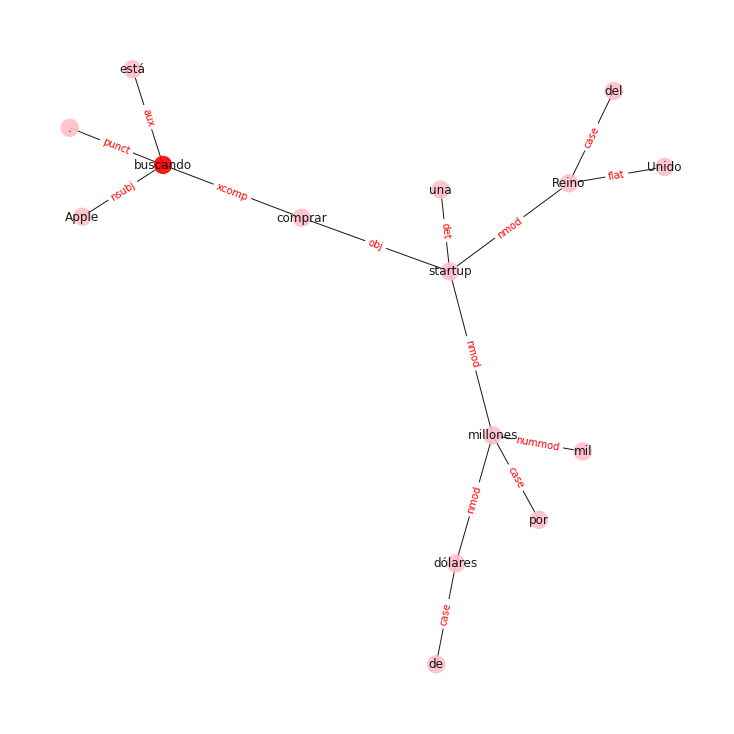

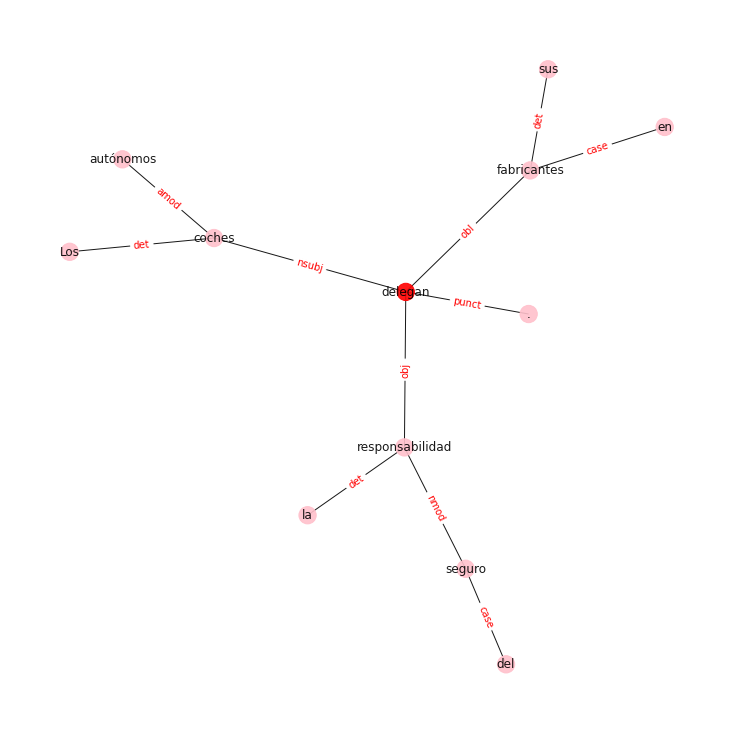

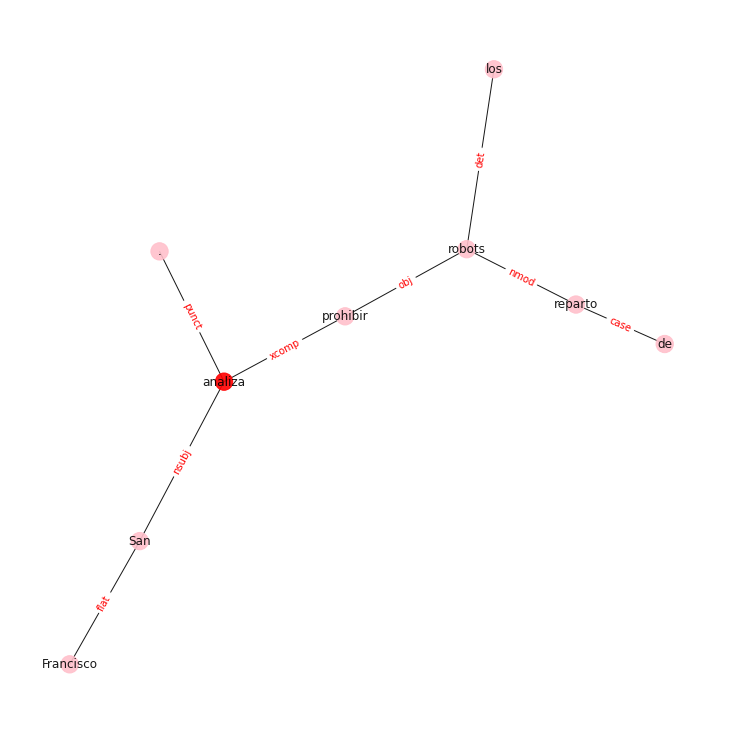

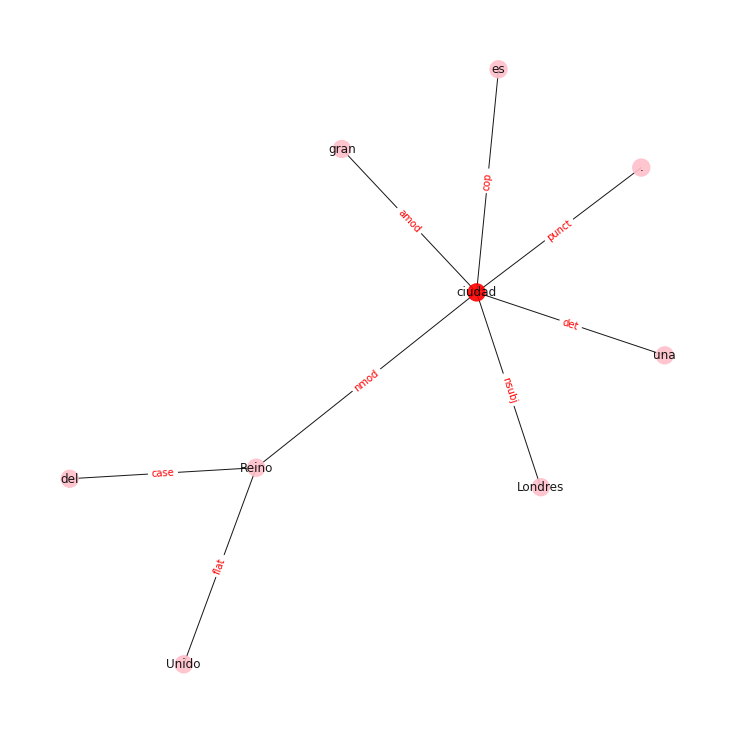

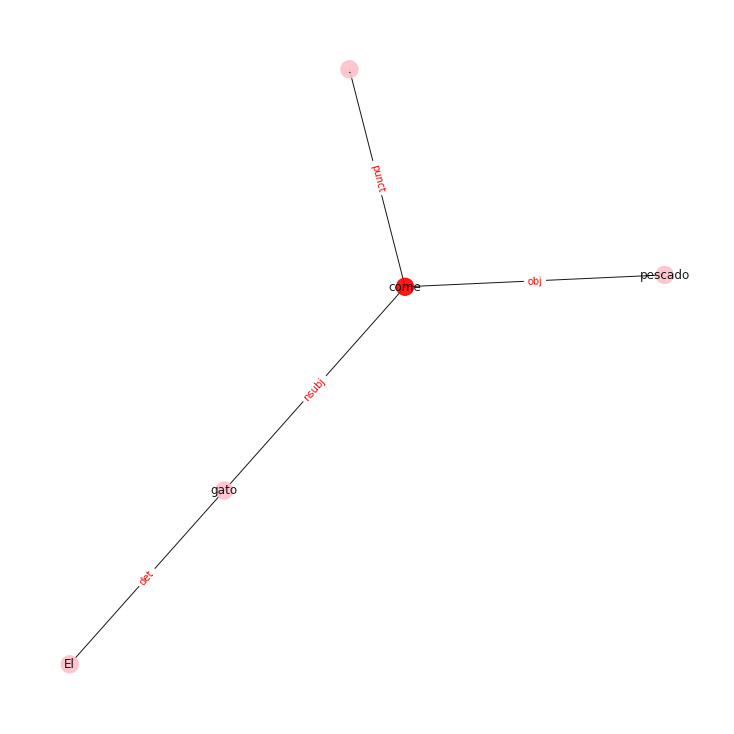

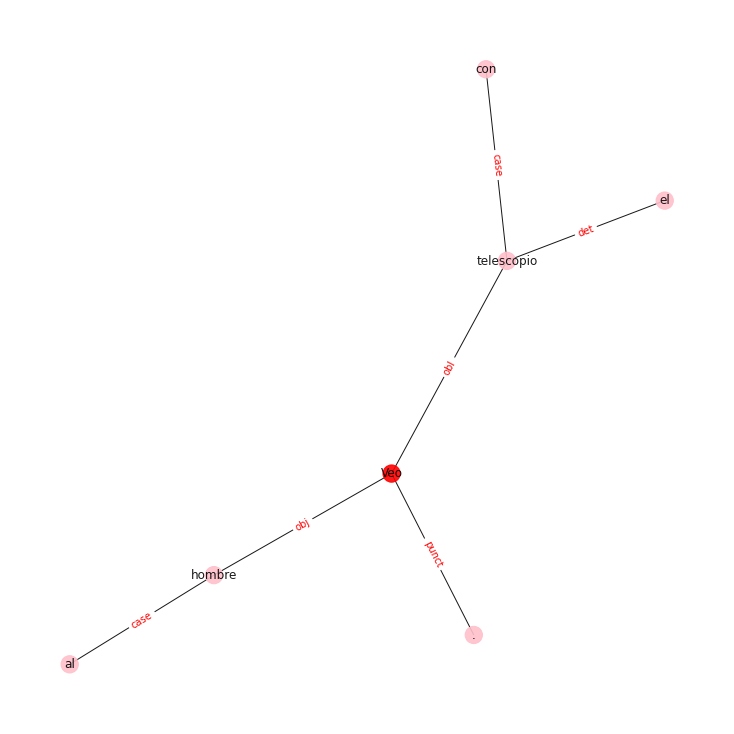

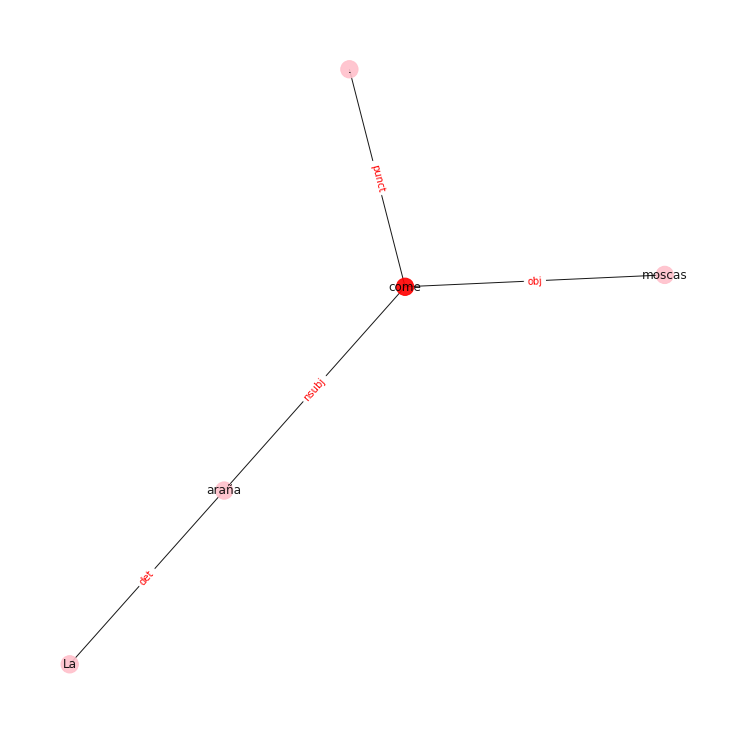

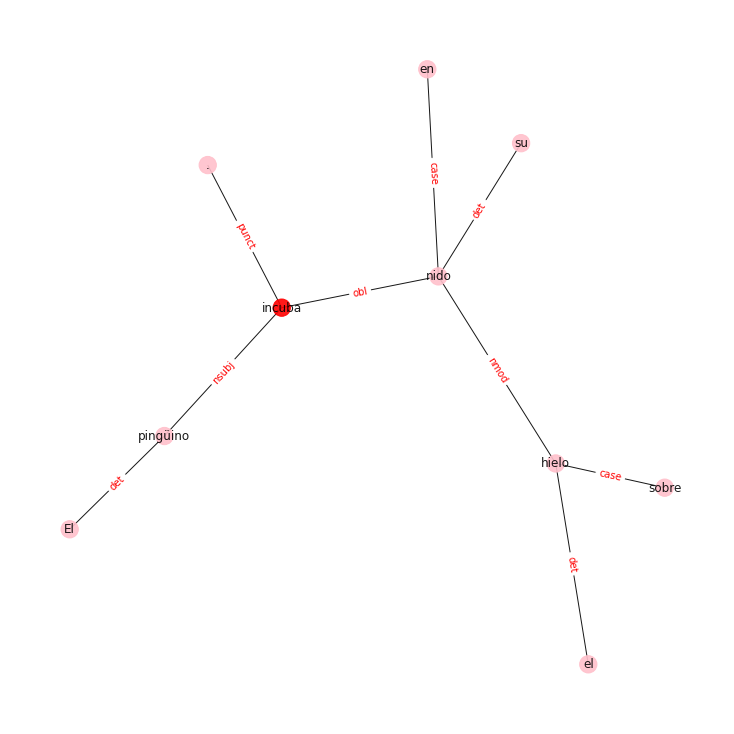

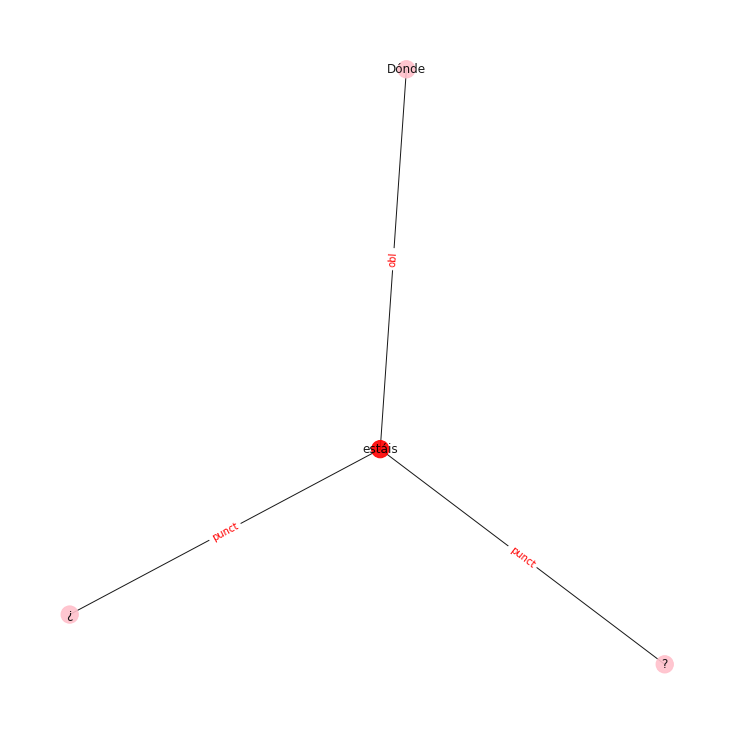

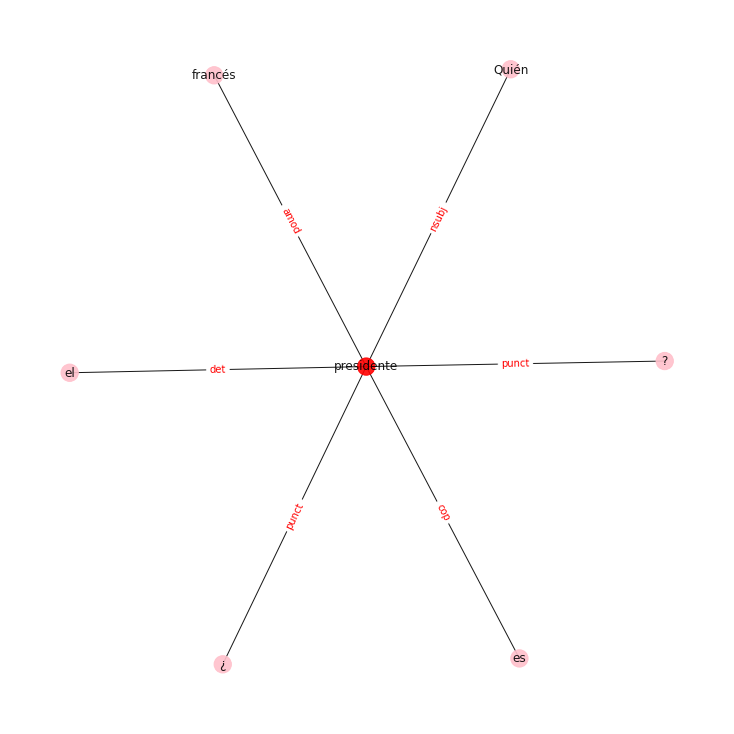

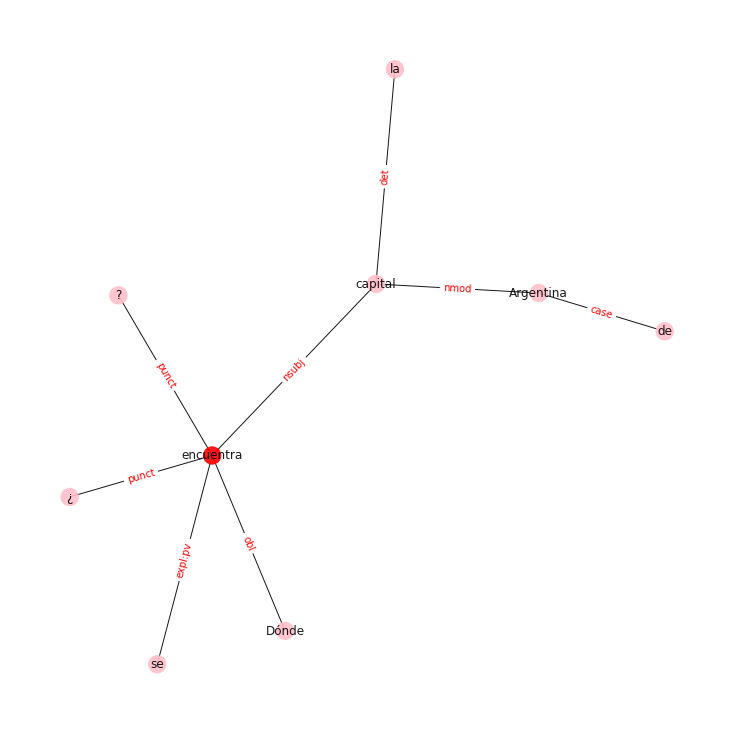

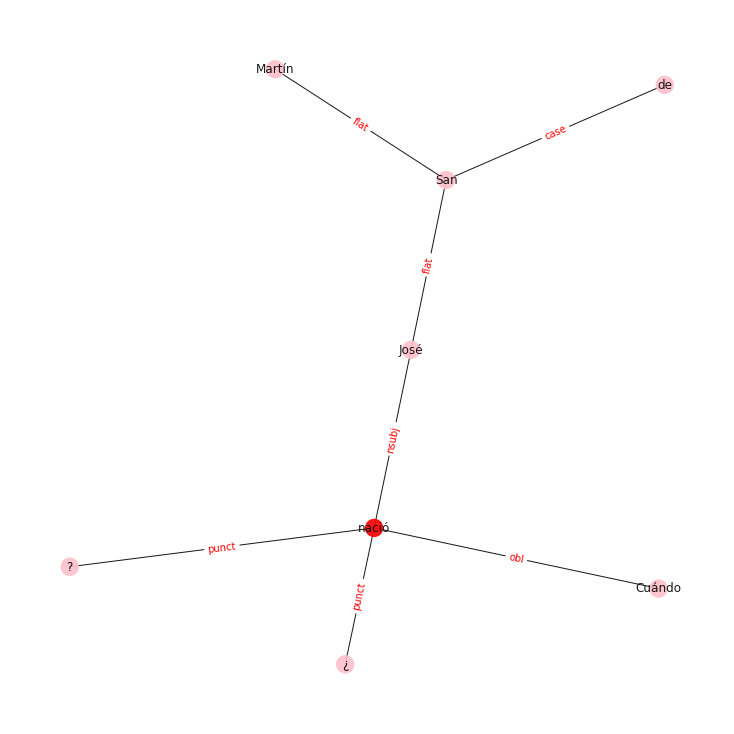

L. - Cuarta


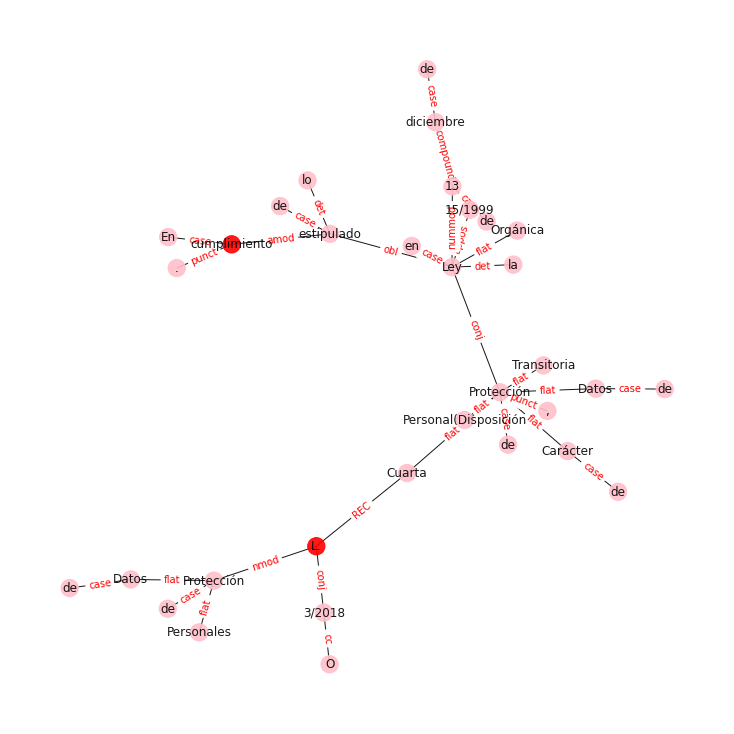

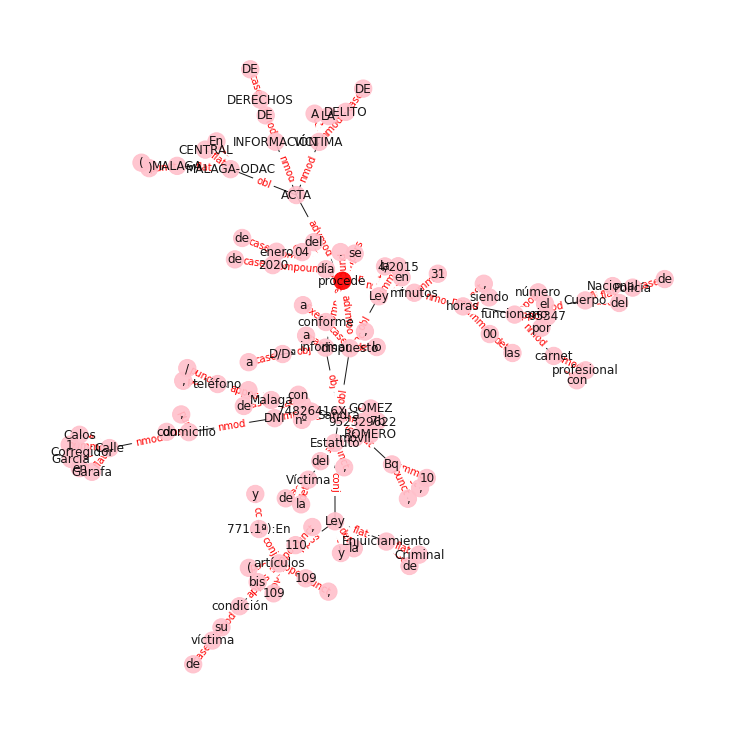

size: 72


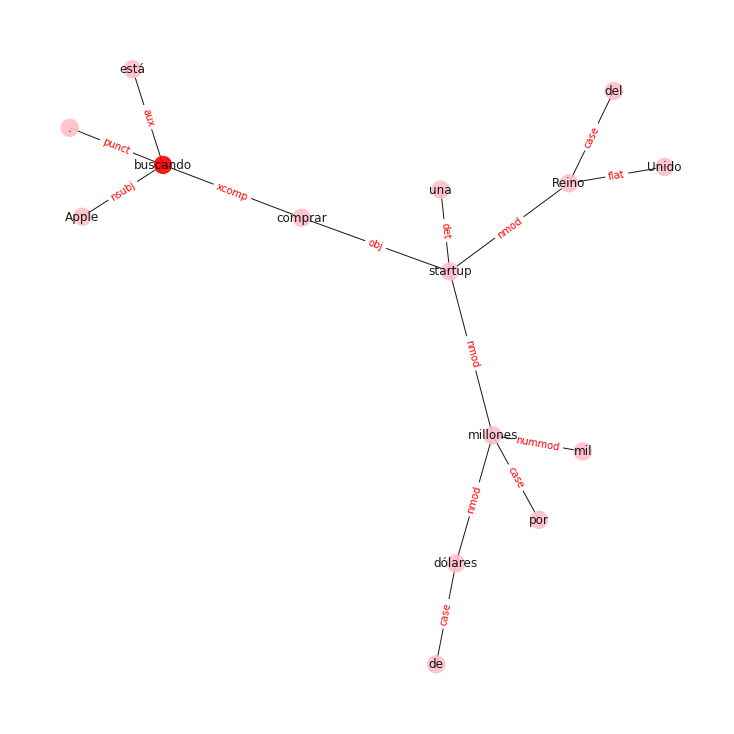

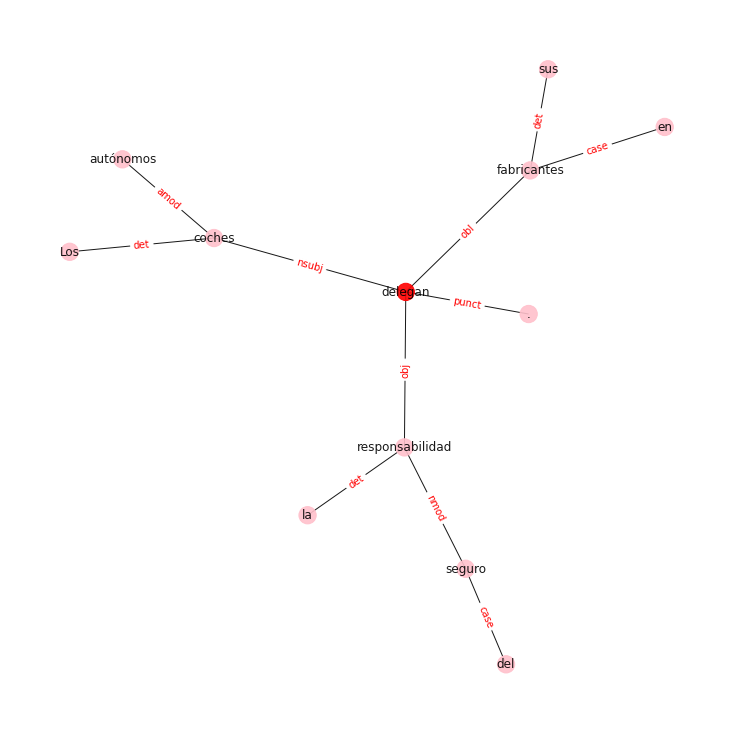

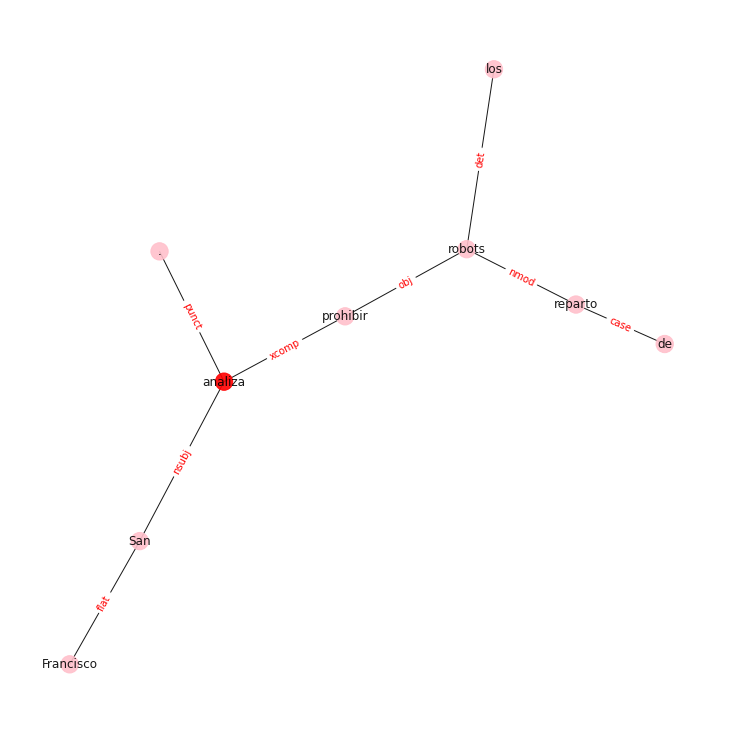

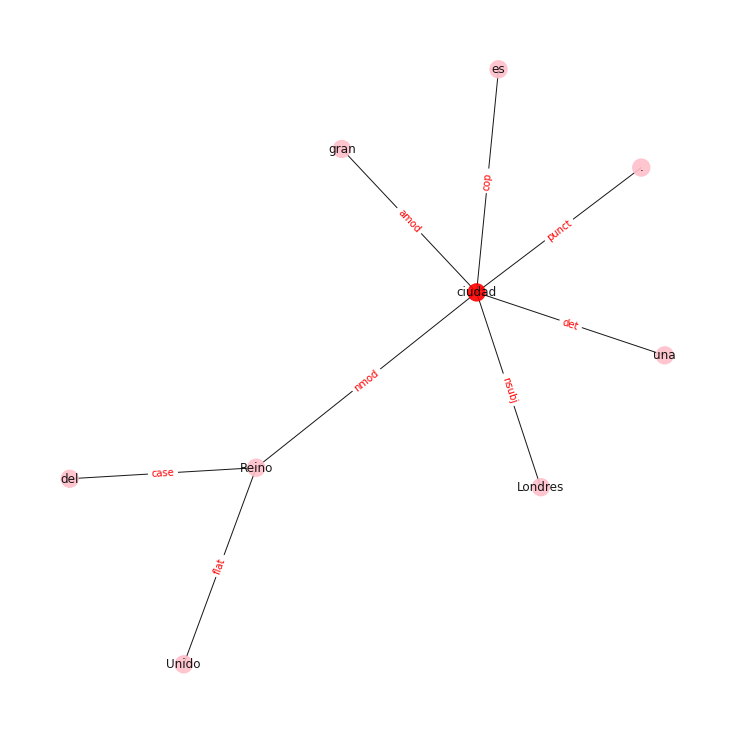

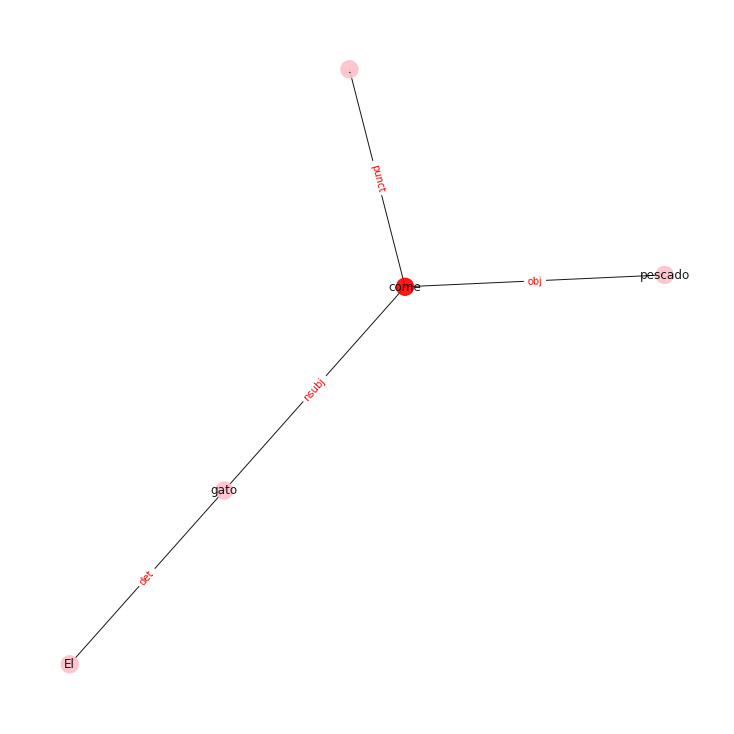

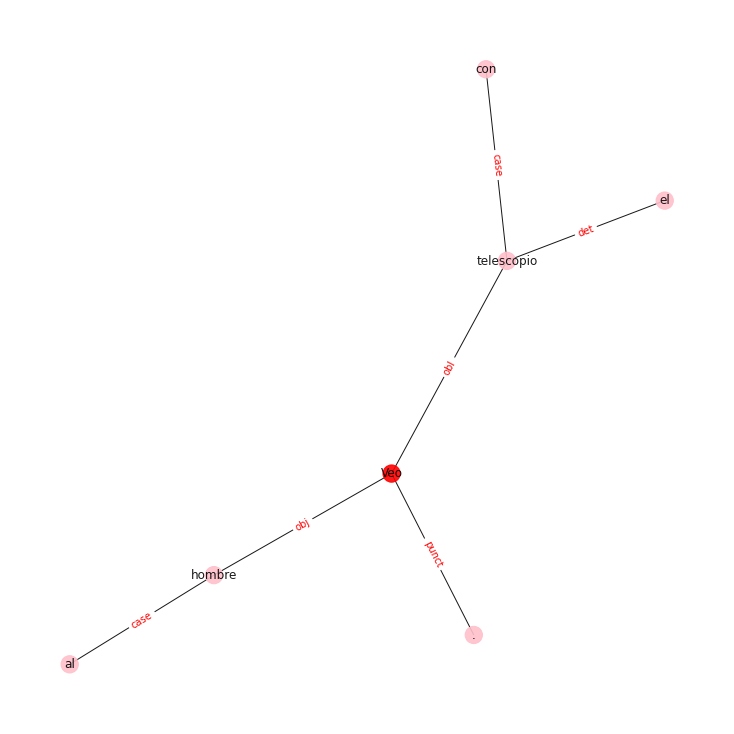

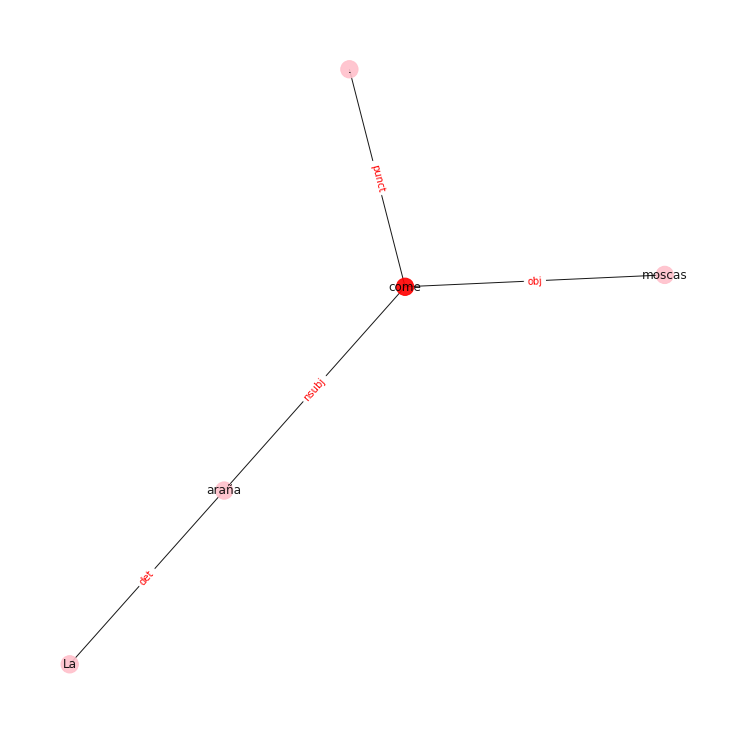

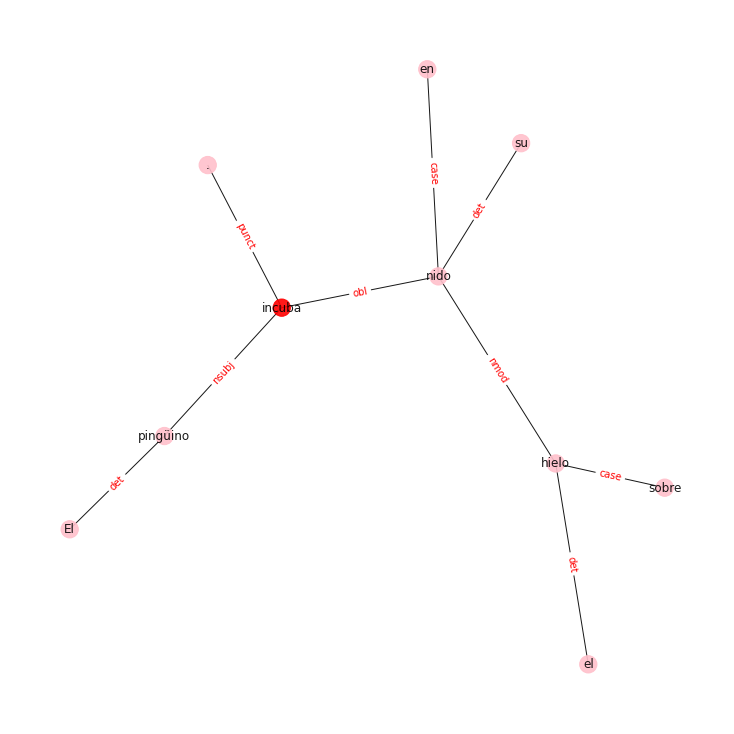

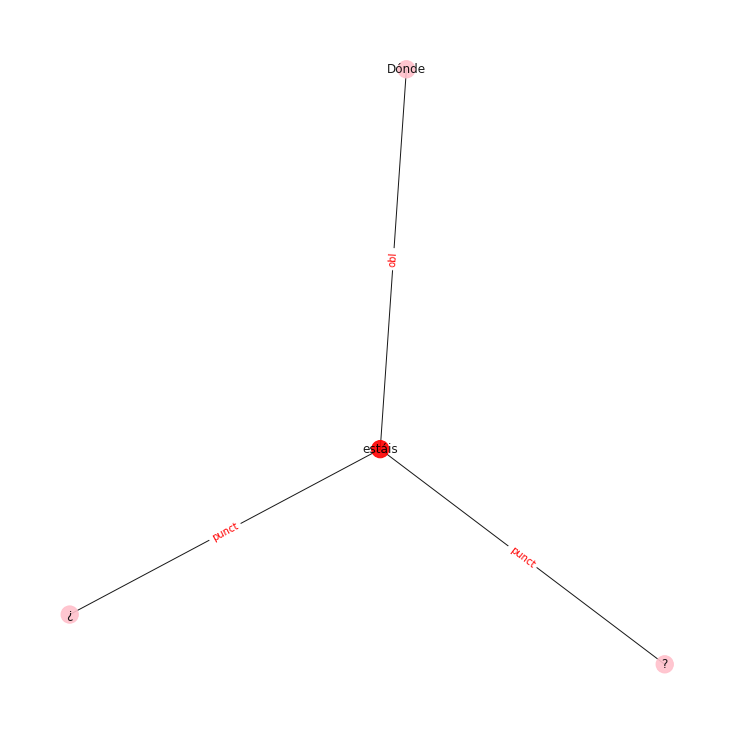

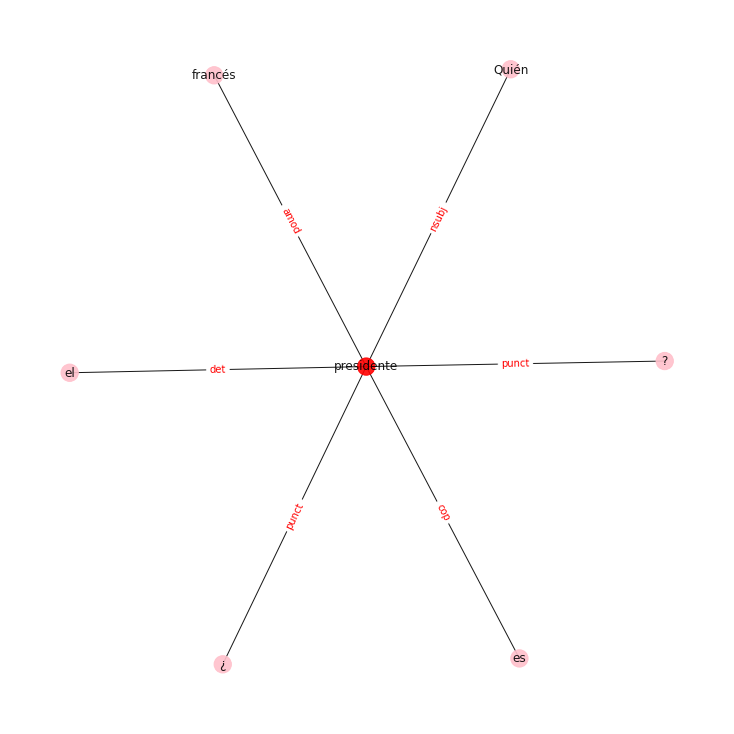

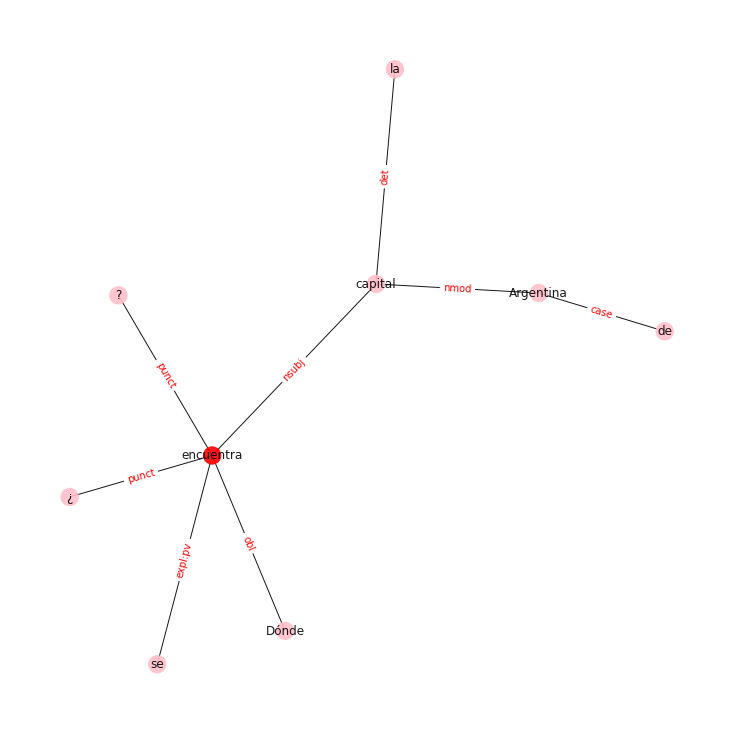

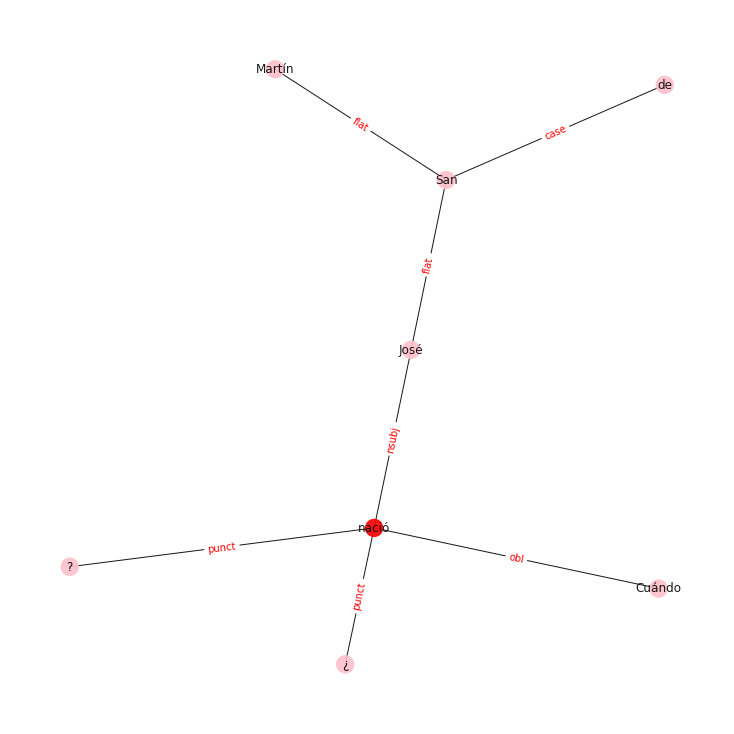

L. - Cuarta


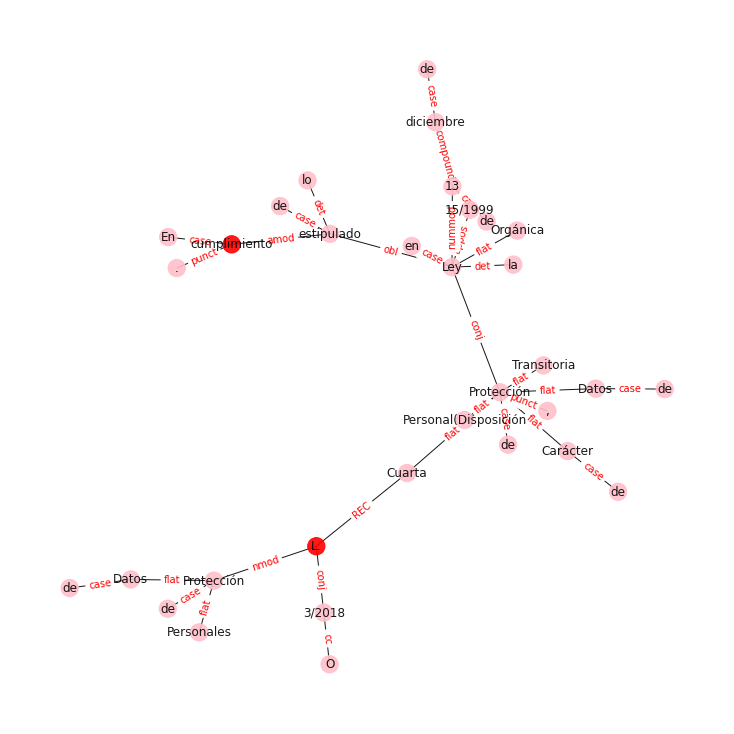

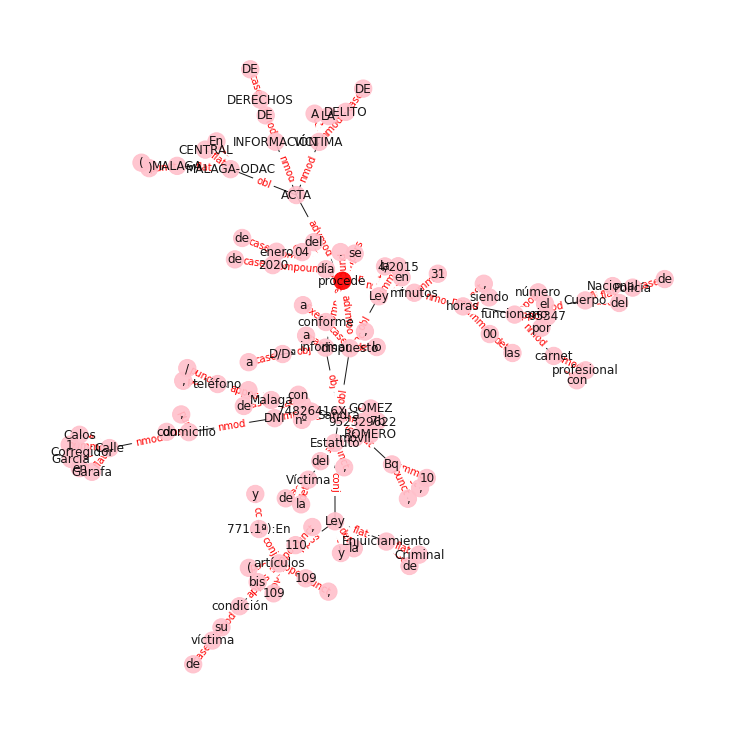

size: 72
ORG_<Apple> buscando comprar startup del LOC_<Reino Unido> 
LOC_<Londres> ciudad del LOC_<Reino Unido> 
LOC_<¿Dónde> encuentra capital de LOC_<Argentina> 
PER_<¿Cuándo> nació PER_<José de San Martín?> 
MISC_<Ley Orgánica> de 13 de diciembre , de Protección Cuarta PER_<L.> 
MISC_<Ley Orgánica> de 13 de diciembre , de Protección Cuarta L. de MISC_<Protección de Datos Personales> 
MISC_<Protección de Datos de Carácter Personal(Disposición Transitoria Cuarta> Cuarta PER_<L.> 
MISC_<Protección de Datos de Carácter Personal(Disposición Transitoria Cuarta> Cuarta L. de MISC_<Protección de Datos Personales> 
ORG_<INFORMACIÓN DE DERECHOS A LA VÍCTIMA DE DELITO> INFORMACIÓN MALAGA-ODAC ( LOC_<MALAGA> 
ORG_<INFORMACIÓN DE DERECHOS A LA VÍCTIMA DE DELITO> INFORMACIÓN minutos funcionario del Cuerpo ORG_<Cuerpo Nacional de Policía> 
ORG_<INFORMACIÓN DE DERECHOS A LA VÍCTIMA DE DELITO> INFORMACIÓN procede informar a PER_<D/Dª Sandra GOMEZ ROMERO> 
ORG_<INFORMACIÓN DE DERECHOS A LA VÍCTIMA DE

In [203]:
sents = []
for s in sentences:
    sents.append(s)
sents.append('En cumplimiento de lo estipulado en la Ley Orgánica 15/1999 de 13 de diciembre, de Protección de Datos de Carácter Personal(Disposición Transitoria Cuarta. L. O 3/2018 de Protección de Datos Personales')
sents.append('ACTA DE INFORMACIÓN DE DERECHOS A LA VÍCTIMA DE DELITO En MALAGA-ODAC CENTRAL (MALAGA), siendo las 00 horas 31 minutos del día 04 de enero de 2020 por el funcionario del Cuerpo Nacional de Policía con carnet profesional número 95347 se procede a informar a D/Dª Sandra GOMEZ ROMERO, con DNI nº 74826416X, con domicilio en Calle Corregidor Calos Garcia Garafa 1, Bq 10, 7b , de Malaga , teléfono/móvil 952329622 , conforme a lo dispuesto en la Ley 4/2015, del Estatuto de la Víctima y la Ley de Enjuiciamiento Criminal (artículos 109, 109 bis, 110 y 771.1ª):En su condición de víctima.')
textual_patterns, post = generate_textual_patterns_with_pos_tags(sents, True, False)
print(f'size: {len(textual_patterns)}')
textual_patterns, post = generate_textual_patterns_with_pos_tags(sents, True, False)
print(f'size: {len(textual_patterns)}')
for pat in textual_patterns: 
    print(pat)
print (f'Done. ')

In [197]:
 doc = nlp(sents[-1])
doc

ACTA DE INFORMACIÓN DE DERECHOS A LA VÍCTIMA DE DELITO En MALAGA-ODAC CENTRAL (MALAGA), siendo las 00 horas 31 minutos del día 04 de enero de 2020 por el funcionario del Cuerpo Nacional de Policía con carnet profesional número 95347 se procede a informar a D/Dª Sandra GOMEZ ROMERO, con DNI nº 74826416X, con domicilio en Calle Corregidor Calos Garcia Garafa 1, Bq 10, 7b , de Malaga , teléfono/móvil 952329622 , conforme a lo dispuesto en la Ley 4/2015, del Estatuto de la Víctima y la Ley de Enjuiciamiento Criminal (artículos 109, 109 bis, 110 y 771.1ª):En su condición de víctima.

In [193]:
doc[0].children

In [59]:
for child in doc[0].children: 
    print (f'{child} - {child.head} - {child.dep_}')

INFORMACIÓN - ACTA - nmod
VÍCTIMA - ACTA - nmod
MALAGA-ODAC - ACTA - obl


ACTA DE INFORMACIÓN DE DERECHOS A LA VÍCTIMA DE DELITO En MALAGA-ODAC CENTRAL (MALAGA), siendo las 00 horas 31 minutos del día 04 de enero de 2020 por el funcionario del Cuerpo Nacional de Policía con carnet profesional número 0000 se procede a informar a D/Dª Manuela Restrigo, con DNI nº 11111123C, con domicilio en Calle Rute, 1,1 , teléfono/móvil 434342 , conforme a lo dispuesto en la Ley 4/2015, del Estatuto de la Víctima y la Ley de Enjuiciamiento Criminal (artículos 109, 109 bis, 110 y 771.1ª):En su condición de víctima.